In [1]:
import socket

In [2]:
socket.gethostname()

'salish.eos.ubc.ca'

In [48]:
import pandas as pd
import netCDF4 as nc
import datetime as dt
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import re
import dateutil as dutil
from salishsea_tools import viz_tools, places, geo_tools, evaltools as et
import glob
import pickle
import matplotlib.dates as mdates
import matplotlib as mpl
import pytz
import matplotlib.ticker as ticker
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey
from sqlalchemy.orm import mapper, create_session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.sql import select, and_, or_, not_, func
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('legend', fontsize=16) 
mpl.rc('axes', titlesize=16) 
mpl.rc('figure', titlesize=16) 
mpl.rc('axes', labelsize=16) 
mpl.rc('font', size=16) 

mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.numpoints'] = 1
%matplotlib inline

In [4]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'ONC/'
dbname='ONCSmallTDP3'

engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite')
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

# existing tables:
TDPTurbTBL=Base.classes.TDPTurbTBL
TDPSalTBL=Base.classes.TDPSalTBL
GriddedTDPTBL=Base.classes.GriddedTDPTBL

session = create_session(bind = engine, autocommit = False, autoflush = True)

In [5]:
session.query(GriddedTDPTBL).count()

784234

In [6]:
df=pd.DataFrame(session.query(GriddedTDPTBL.Year,GriddedTDPTBL.Month,GriddedTDPTBL.Day,GriddedTDPTBL.Hour,GriddedTDPTBL.Modeli,GriddedTDPTBL.Modelj,
                        GriddedTDPTBL.MLat,GriddedTDPTBL.MLon,GriddedTDPTBL.AvgTurb_NTU,GriddedTDPTBL.AvgSA,GriddedTDPTBL.N_Turb,GriddedTDPTBL.N_SA).\
                filter(and_(GriddedTDPTBL.Year>=2015,GriddedTDPTBL.Year<=2016)).all())

In [7]:
df.loc[df.N_SA>0].head()

,Year,Month,Day,Hour,Modeli,Modelj,MLat,MLon,AvgTurb_NTU,AvgSA,N_Turb,N_SA
0,2015,1,1,0,226.0,487.0,49.212452,-123.847458,2.89500,26.469050,2,1.0
1,2015,1,1,0,227.0,487.0,49.214344,-123.842270,2.64410,26.481832,4,5.0
2,2015,1,1,0,228.0,487.0,49.216236,-123.837082,2.47040,26.478621,5,4.0
3,2015,1,1,0,229.0,487.0,49.218128,-123.831894,2.50900,26.485228,4,5.0
4,2015,1,1,0,230.0,487.0,49.220016,-123.826706,2.74832,26.491357,5,5.0


In [8]:
df.loc[df.N_SA>0].tail()

,Year,Month,Day,Hour,Modeli,Modelj,MLat,MLon,AvgTurb_NTU,AvgSA,N_Turb,N_SA
645089,2016,11,15,8,300.0,398.0,49.002956,-123.164993,5.599333,26.816429,3,2.0
645090,2016,11,15,8,301.0,397.0,49.000916,-123.156441,5.609200,26.545483,5,5.0
645091,2016,11,15,8,302.0,397.0,49.002808,-123.151237,5.416800,27.628397,5,5.0
645092,2016,11,15,8,303.0,396.0,49.000771,-123.142685,5.143000,27.944559,8,9.0
645094,2016,11,15,8,304.0,396.0,49.002663,-123.137482,4.999111,27.885943,9,9.0


In [9]:
df2=df.loc[(df.N_Turb>2)&(df.N_SA>2)].copy(deep=True)

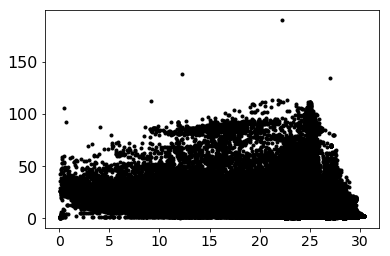

In [10]:
plt.plot(df2['AvgSA'],df2['AvgTurb_NTU'],'k.')

newlen= 276807


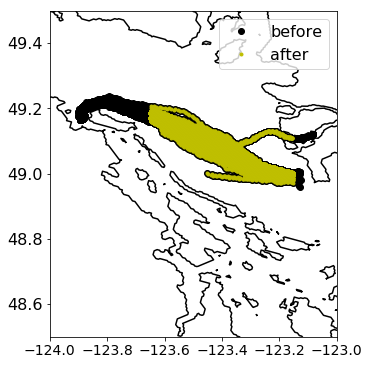

In [11]:
# chop off ends:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(df2['MLon'],df2['MLat'], 'ko',label='before')
df2.drop(df2.loc[(df2.MLon<-123.65)|(df2.MLon>-123.15)].index,inplace=True)
ax.plot(df2['MLon'],df2['MLat'],'y.',label='after')
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.5, 49.5)
ax.legend()
ax.set_xlim(-124., -123);

print('newlen=',len(df2))

In [12]:
df2['Lon']=df2['MLon']
df2['Lat']=df2['MLat']
df2['dtUTC']=[dt.datetime(yy,mm,dd,hh)+dt.timedelta(minutes=30) for yy,mm,dd,hh in zip(df2['Year'],df2['Month'],df2['Day'],df2['Hour'])]

In [13]:
df2.head()

,Year,Month,Day,Hour,Modeli,Modelj,MLat,MLon,AvgTurb_NTU,AvgSA,N_Turb,N_SA,Lon,Lat,dtUTC
39,2015,1,1,0,252.0,466.0,49.179226,-123.642265,3.176229,24.123264,7,7.0,-123.642265,49.179226,2015-01-01 00:30:00
42,2015,1,1,0,253.0,465.0,49.177193,-123.633728,3.165200,23.677930,6,7.0,-123.633728,49.177193,2015-01-01 00:30:00
44,2015,1,1,0,254.0,464.0,49.175159,-123.625191,3.229533,23.384193,6,6.0,-123.625191,49.175159,2015-01-01 00:30:00
45,2015,1,1,0,255.0,462.0,49.169201,-123.613297,3.319600,23.183823,4,3.0,-123.613297,49.169201,2015-01-01 00:30:00
46,2015,1,1,0,255.0,463.0,49.173126,-123.616646,3.281000,22.992757,4,5.0,-123.616646,49.173126,2015-01-01 00:30:00


In [14]:
df3=df2.iloc[1::20,:].copy(deep=True)

In [15]:
len(df2),len(df3)

(276807, 13841)

In [16]:
PATH= '/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2017,1,1) #end of current ONC file is <2017 7 3
flen=1
namfmt='nowcast'
filemap={'Fraser_tracer':'turb_T','vosaline':'grid_T'}
fdict={'turb_T':1,'grid_T':1}

In [17]:
it0=dt.datetime.now()
print(it0)
data=et.matchData(df3,filemap, fdict, start_date, end_date, namfmt, PATH, flen,wrapSearch=True,wrapTol=12,method='ferry')
print(dt.datetime.now()-it0)

2019-05-03 20:35:12.343410
ftype=turb_T, are you sure? (if yes, add to list)
data is matched to mean of upper 3 model levels
done index turb_T 2019-05-03 20:37:54.684630
turb_T progress: 0.0%
turb_T progress: 9.999277508850517%
turb_T progress: 19.998555017701033%
turb_T progress: 29.997832526551548%
turb_T progress: 39.997110035402066%
turb_T progress: 49.996387544252585%
turb_T progress: 59.995665053103096%
turb_T progress: 69.99494256195362%
turb_T progress: 79.99422007080413%
turb_T progress: 89.99349757965464%
turb_T progress: 99.99277508850517%
done index grid_T 2019-05-03 21:36:09.111060
grid_T progress: 0.0%
grid_T progress: 9.999277508850517%
grid_T progress: 19.998555017701033%
grid_T progress: 29.997832526551548%
grid_T progress: 39.997110035402066%
grid_T progress: 49.996387544252585%
grid_T progress: 59.995665053103096%
grid_T progress: 69.99494256195362%
grid_T progress: 79.99422007080413%
grid_T progress: 89.99349757965464%
grid_T progress: 99.99277508850517%
2:04:47.076

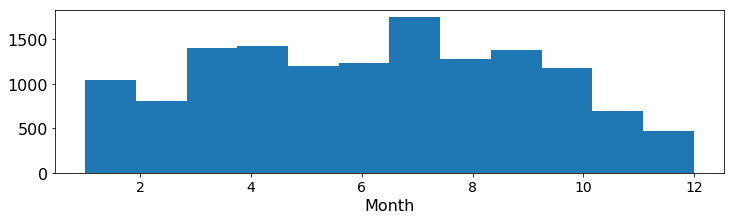

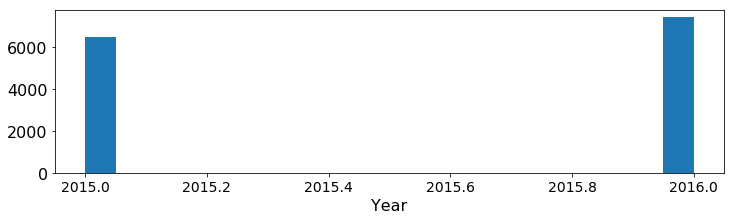

In [18]:
fig,ax=plt.subplots(figsize=(12,3))
ax.hist([xx.month for xx in data['dtUTC']],12)
ax.set_xlabel('Month')
fig,ax=plt.subplots(figsize=(12,3))
ax.hist([xx.year for xx in data['dtUTC']],20)
ax.set_xlabel('Year')

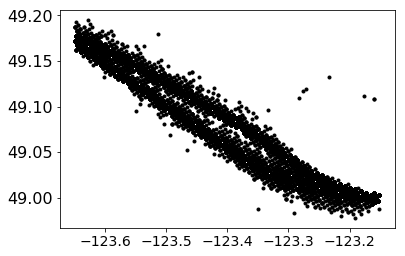

In [19]:
plt.plot(data['Lon'],data['Lat'],'k.')

In [20]:
data.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Modeli', 'Modelj', 'MLat', 'MLon',
       'AvgTurb_NTU', 'AvgSA', 'N_Turb', 'N_SA', 'Lon', 'Lat', 'dtUTC', 'j',
       'i', 'mod_Fraser_tracer', 'mod_vosaline', 'indf_turb_T', 'ih_turb_T',
       'indf_grid_T', 'ih_grid_T'],
      dtype='object')

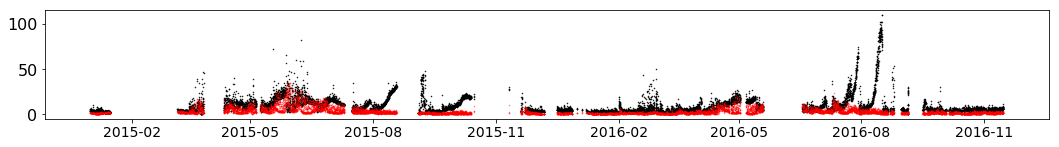

In [21]:
fig,ax=plt.subplots(figsize=(18,2))
data1516=data.loc[(data.dtUTC<dt.datetime(2017,1,1))]
ax.plot(data1516['dtUTC'],data1516['AvgTurb_NTU'],'k.',ms=1)
ax.plot(data1516['dtUTC'],data1516['mod_Fraser_tracer'],'r.',ms=1,alpha=.5)

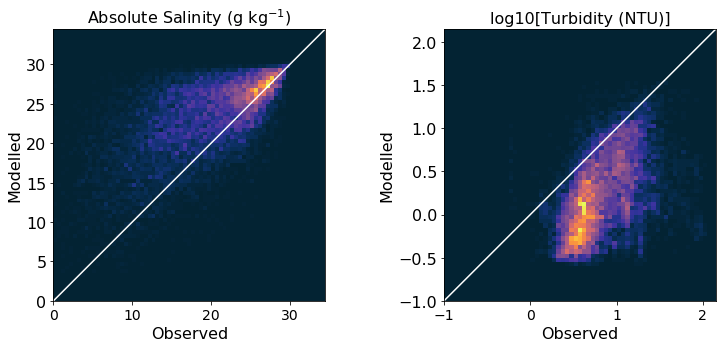

In [44]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
fig.subplots_adjust(wspace=.4)
h,x,y,m=ax[1].hist2d(np.log10(data1516['AvgTurb_NTU']),np.log10(data1516['mod_Fraser_tracer']),np.arange(-1,2.2,.05),cmap=cmocean.cm.thermal);
ax[1].set_xlabel('Observed')
ax[1].set_ylabel('Modelled')
ax[1].plot((-2,3),(-2,3),'w-')
ax[1].set_title('log10[Turbidity (NTU)]')
ax[1].set_aspect(1)
#fig.colorbar(m,ax=ax[1])
h,x,y,m2=ax[0].hist2d(data1516['AvgSA'],data1516['mod_vosaline'],np.arange(0,35,.5),cmap=cmocean.cm.thermal);
ax[0].set_xlabel('Observed')
ax[0].set_ylabel('Modelled')
ax[0].plot((0,35),(0,35),'w-')
ax[0].set_title('Absolute Salinity (g kg$^{-1}$)')
ax[0].set_aspect(1)
#fig.colorbar(m2,ax=ax[0])

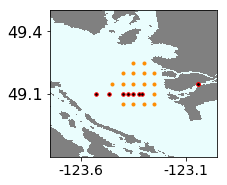

In [49]:
fig,ax=plt.subplots(1,1,figsize=(3,3))
def add_map(ax):
    cmap=plt.get_cmap(cmocean.cm.ice_r)
    cmap.set_bad('gray')
    ax.pcolormesh(navlon,navlat,np.ma.masked_where(tmask[0,0,:,:]==0,tmask[0,0,:,:]),cmap=cmap)
    ax.set_xlim((-123.75,-122.95))
    ax.set_ylim((48.8,49.5))
    ax.plot([-123.04000000000001, -123.04000000000001, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.34999999999999, -123.32466670000001, -123.309],
            [49.14833333, 49.14833333, 49.099983330000001, 49.10038333, 49.100583329999999, 49.100499999999997, 49.100000000000001, 49.100333329999998, 49.101500000000001],
            'r.',ms=7)
    ax.plot([-123.04000000000001, -123.04000000000001, -123.5266, -123.46701670000002, -123.40041670000001, -123.3755, -123.34999999999999, -123.32466670000001, -123.309],
            [49.14833333, 49.14833333, 49.099983330000001, 49.10038333, 49.100583329999999, 49.100499999999997, 49.100000000000001, 49.100333329999998, 49.101500000000001],
            'k.',ms=3)
    ax.plot([-123.45, -123.4, -123.35, -123.3, -123.25,-123.25, -123.4, -123.35, -123.3, -123.25, -123.35, -123.3, -123.4, -123.35, -123.3, -123.25],
            [49.15, 49.15, 49.15, 49.15, 49.15,49.1,49.2, 49.2, 49.2, 49.2,49.25, 49.25, 49.05, 49.05, 49.05, 49.05],
            '.',color='darkorange')
    xmajors=(-123.6,-123.1)
    ymajors=(49.1,49.4)
    ax.xaxis.set_ticks(xmajors)
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(xmajors))
    ax.yaxis.set_ticks(ymajors)
    ax.set_aspect('equal')
    return ax
add_map(ax)

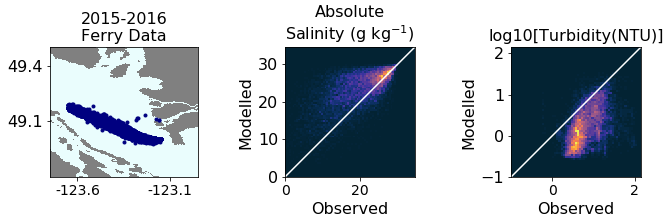

In [69]:
fig,ax=plt.subplots(1,3,figsize=(11,3))
fig.subplots_adjust(wspace=.4,bottom=.2,top=.8)
h,x,y,m=ax[2].hist2d(np.log10(data1516['AvgTurb_NTU']),np.log10(data1516['mod_Fraser_tracer']),np.arange(-1,2.2,.05),cmap=cmocean.cm.thermal);
ax[2].set_xlabel('Observed')
ax[2].set_ylabel('Modelled')
ax[2].plot((-2,3),(-2,3),'w-')
ax[2].set_title('log10[Turbidity(NTU)]')
ax[2].set_aspect(1)
#fig.colorbar(m,ax=ax[1])
h,x,y,m2=ax[1].hist2d(data1516['AvgSA'],data1516['mod_vosaline'],np.arange(0,35,.5),cmap=cmocean.cm.thermal);
ax[1].set_xlabel('Observed')
ax[1].set_ylabel('Modelled')
ax[1].plot((0,35),(0,35),'w-')
ax[1].set_title('Salinity (g kg$^{-1}$)')
ax[1].set_aspect(1)
cmap=plt.get_cmap(cmocean.cm.ice_r)
cmap.set_bad('gray')
ax[0].pcolormesh(navlon,navlat,np.ma.masked_where(tmask[0,0,:,:]==0,tmask[0,0,:,:]),cmap=cmap)
ax[0].set_xlim((-123.75,-122.95))
ax[0].set_ylim((48.8,49.5))
xmajors=(-123.6,-123.1)
ymajors=(49.1,49.4)
ax[0].xaxis.set_ticks(xmajors)
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(xmajors))
ax[0].yaxis.set_ticks(ymajors)
ax[0].plot(data1516['Lon'],data1516['Lat'],'.',color='navy')
ax[0].set_aspect('equal')
ax[0].set_title('2015-2016\nFerry Data')
fig.savefig('/home/eolson/pyCode/notebooks/figs/ferrySalTurb.png',dpi=200,transparent=True)
#fig.colorbar(m2,ax=ax[0])

In [70]:

pickle.dump(data,open('/data/eolson/MEOPAR/SS36runs/calcFiles/dataForONCFerryTurbSalTDP.pkl','wb'))

In [23]:
def _rmse(delf):
    return np.sqrt(np.mean(np.power(delf,2)))
_rmse.__name__='RMSE'

In [24]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    tmask=np.copy(fm.variables['tmask'])
    umask=np.copy(fm.variables['umask'])
    vmask=np.copy(fm.variables['vmask'])
    navlon=np.copy(fm.variables['nav_lon'])
    navlat=np.copy(fm.variables['nav_lat'])
    e3t_0=np.copy(fm.variables['e3t_0'])
    e3u_0=np.copy(fm.variables['e3u_0'])
    e3v_0=np.copy(fm.variables['e3v_0'])
    e1t=np.copy(fm.variables['e1t'])
    e2t=np.copy(fm.variables['e2t'])
    e1v=np.copy(fm.variables['e1v'])
    e2u=np.copy(fm.variables['e2u'])
    A=fm.variables['e1t'][0,:,:]*fm.variables['e2t'][0,:,:]*tmask[0,0,:,:]
    lmask=-1*(tmask[0,0,:,:]-1)

In [25]:
data['ER']=data['l10_modChl']-data['l10_obsChl']
agg={'ER':[_rmse,'mean'],
     'Chl':'count'}
df3=data.groupby(['i','j'],as_index=False).agg(agg)
df3.columns = ['_'.join(tup).rstrip('_') for tup in df3.columns.values]
df3=df3.reindex()

KeyError: 'l10_modChl'

In [ ]:
df3

In [ ]:
blank=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
blank2=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
for ind, r in df3.iterrows():
    blank[int(r['j']),int(r['i'])]=r['ER_RMSE']
    blank2[int(r['j']),int(r['i'])]=r['ER_mean']
fig,ax=plt.subplots(1,2,figsize=(12,5))
iax=ax[0]
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank),vmin=0,vmax=1.)
iax.set_xlim(210,320)
iax.set_ylim(390,500)
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('RMSE log10 Chl')
iax=ax[1]
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank2),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
iax.set_xlim(210,320)
iax.set_ylim(390,500)
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('bias log10 Chl')

In [ ]:
blank=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
blank2=np.nan*np.ones(np.shape(tmask[0,0,:,:]))
for ind, r in df3.iterrows():
    if r['Chl_count']>=3:
        blank[int(r['j']),int(r['i'])]=r['ER_RMSE']
        blank2[int(r['j']),int(r['i'])]=r['ER_mean']
fig,ax=plt.subplots(1,2,figsize=(12,5))
iax=ax[0]
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank),vmin=0,vmax=1.)
iax.set_xlim(210,320)
iax.set_ylim(390,500)
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('RMSE log10 Chl, n>2')
iax=ax[1]
m=iax.pcolormesh(np.ma.masked_where(np.isnan(blank),blank2),vmin=-1,vmax=1,cmap=cmocean.cm.balance)
iax.set_xlim(210,320)
iax.set_ylim(390,500)
viz_tools.set_aspect(iax);
fig.colorbar(m,ax=iax)
iax.set_title('bias log10 Chl, n>2')

In [ ]:
Ns,ex,ey=np.histogram2d(data['l10_obsChl'],data['l10_modChl'],np.arange(-2,2.0,.05));
plt.pcolormesh(ex,ey,Ns.T)